In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, optimizers, layers, metrics
from PipelineStages import Loader, ImageProcessing, Labeler, DatasetBuilder, ModelTrainer

2023-07-15 16:36:58.096918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Normalization())
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

def architecture_3(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.RandomFlip())
    network.add(layers.RandomRotation(1))
    network.add(layers.Normalization())
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    #network.add(layers.MaxPooling2D(pool_size=(2, 2)))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Flatten())
    network.add(layers.Dense(n_filters[1], activation='sigmoid'))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

In [3]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 25ms/"
n_tweezers = 100
n_loops = 20

In [4]:
loader = Loader.Loader(n_tweezers, n_loops, path, path + "/model1.h5")
combined_stack, model, n_files = loader.run()

AttributeError: 'Loader' object has no attribute 'run'

In [ ]:
print(combined_stack.shape)

(7, 3700, 80, 80)


In [ ]:
combined_stack = np.reshape(combined_stack, (n_files, -1, *combined_stack.shape[-2:]))

All brightness values for tweezer 61 are above the lower threshold!
No images for this tweezer can be labeled dark!
All brightness values for tweezer 67 are above the lower threshold!
No images for this tweezer can be labeled dark!
All brightness values for tweezer 73 are above the lower threshold!
No images for this tweezer can be labeled dark!
All brightness values for tweezer 83 are above the lower threshold!
No images for this tweezer can be labeled dark!
All brightness values for tweezer 87 are above the lower threshold!
No images for this tweezer can be labeled dark!
All brightness values for tweezer 88 are above the lower threshold!
No images for this tweezer can be labeled dark!
All brightness values for tweezer 23 are above the lower threshold!
No images for this tweezer can be labeled dark!


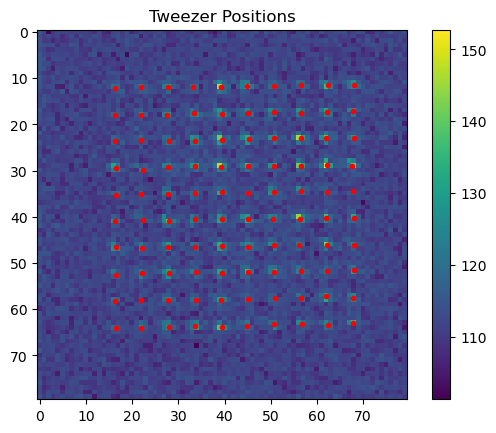

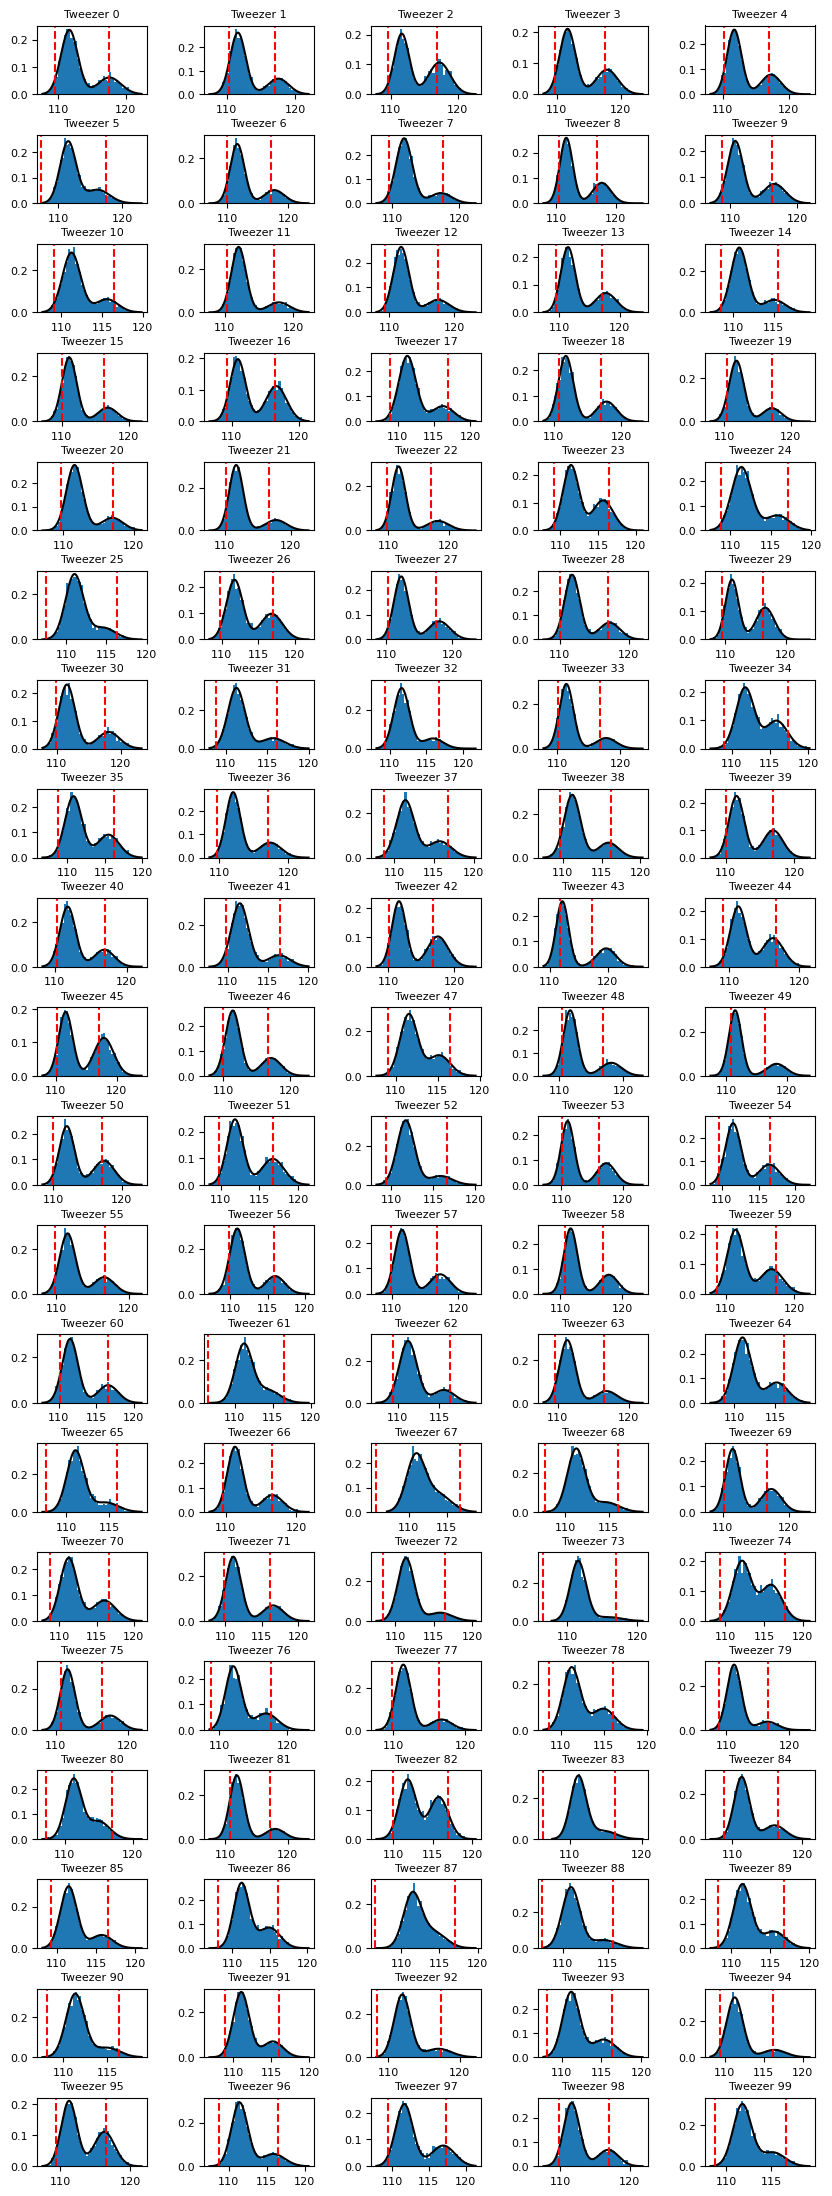

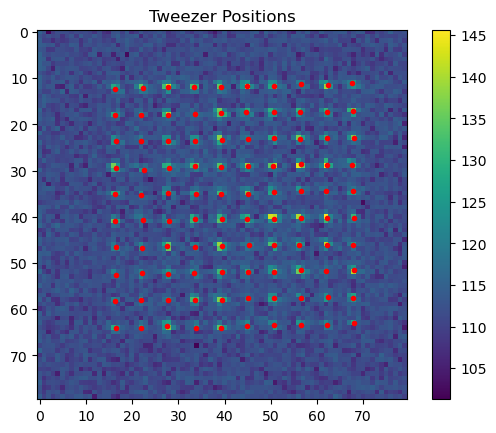

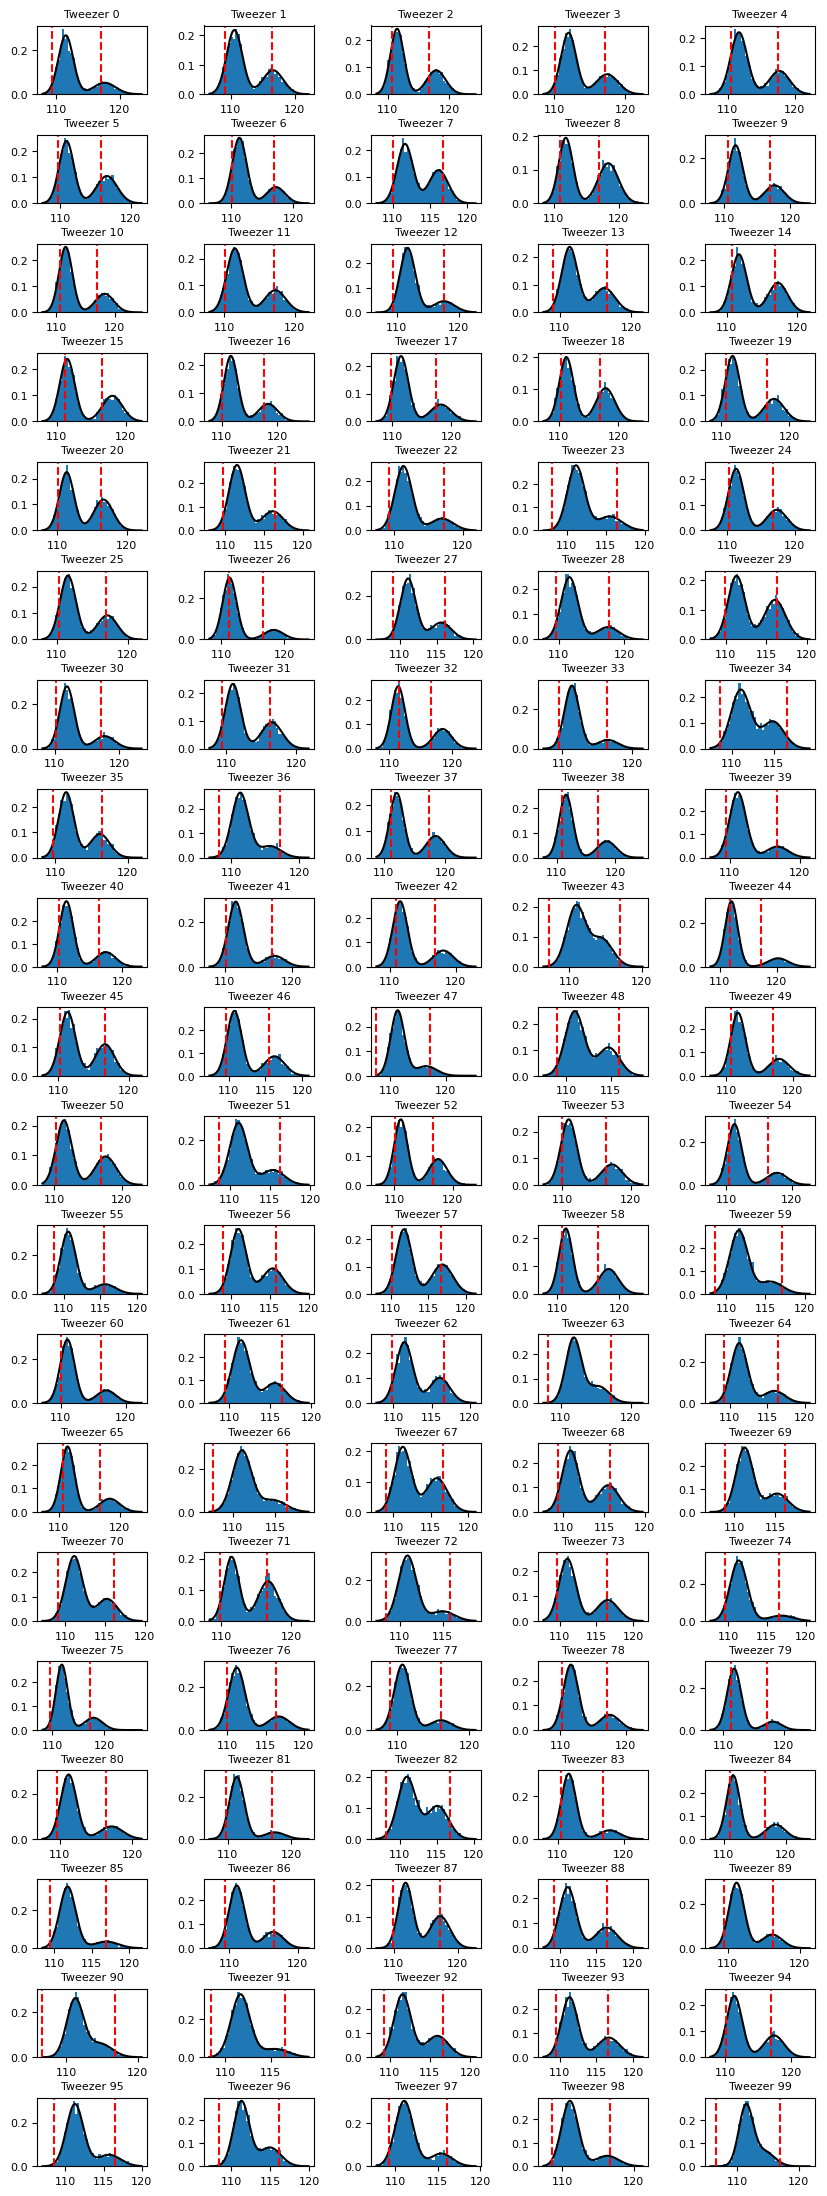

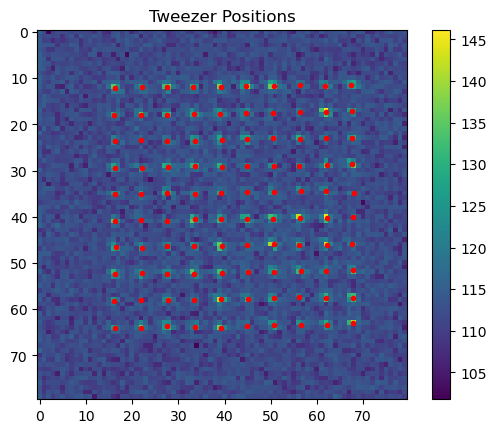

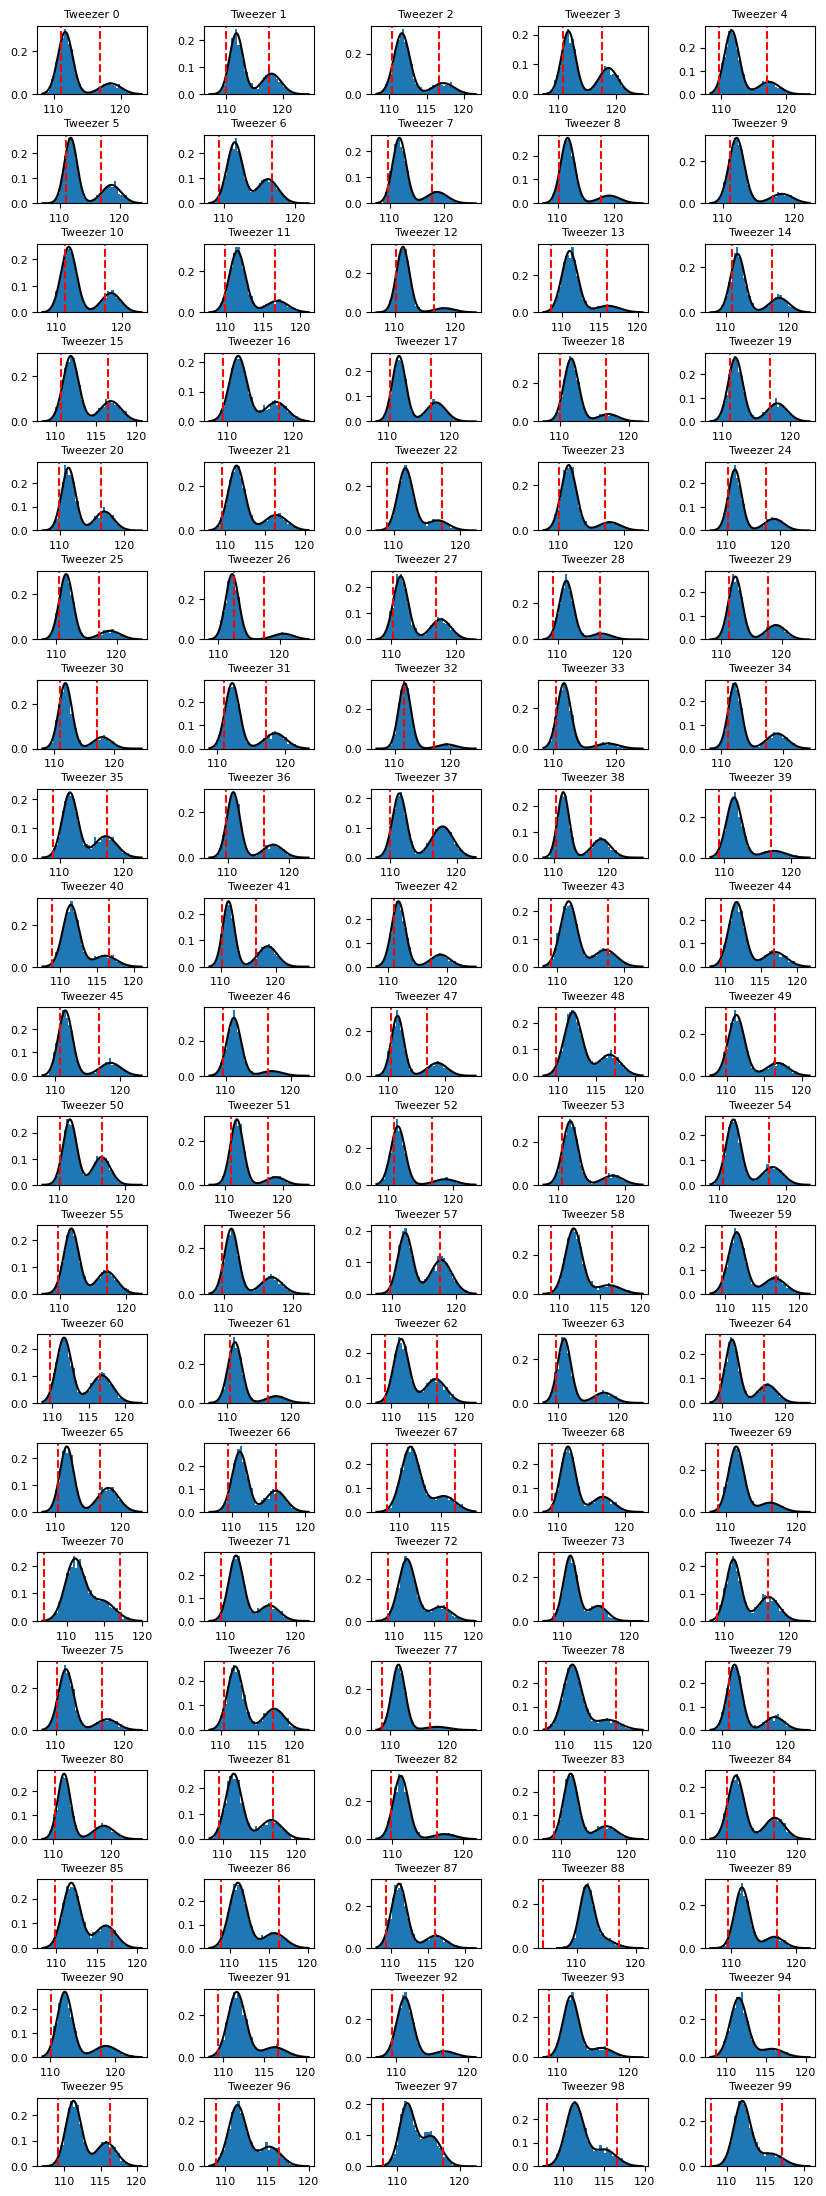

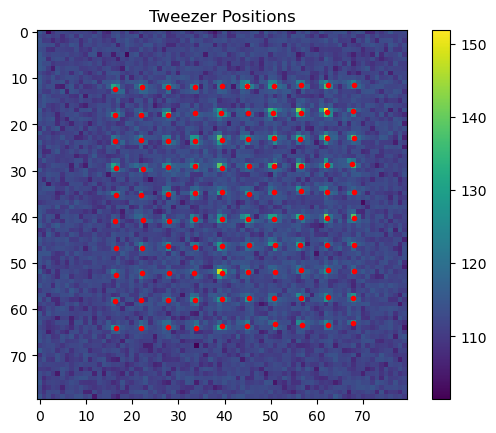

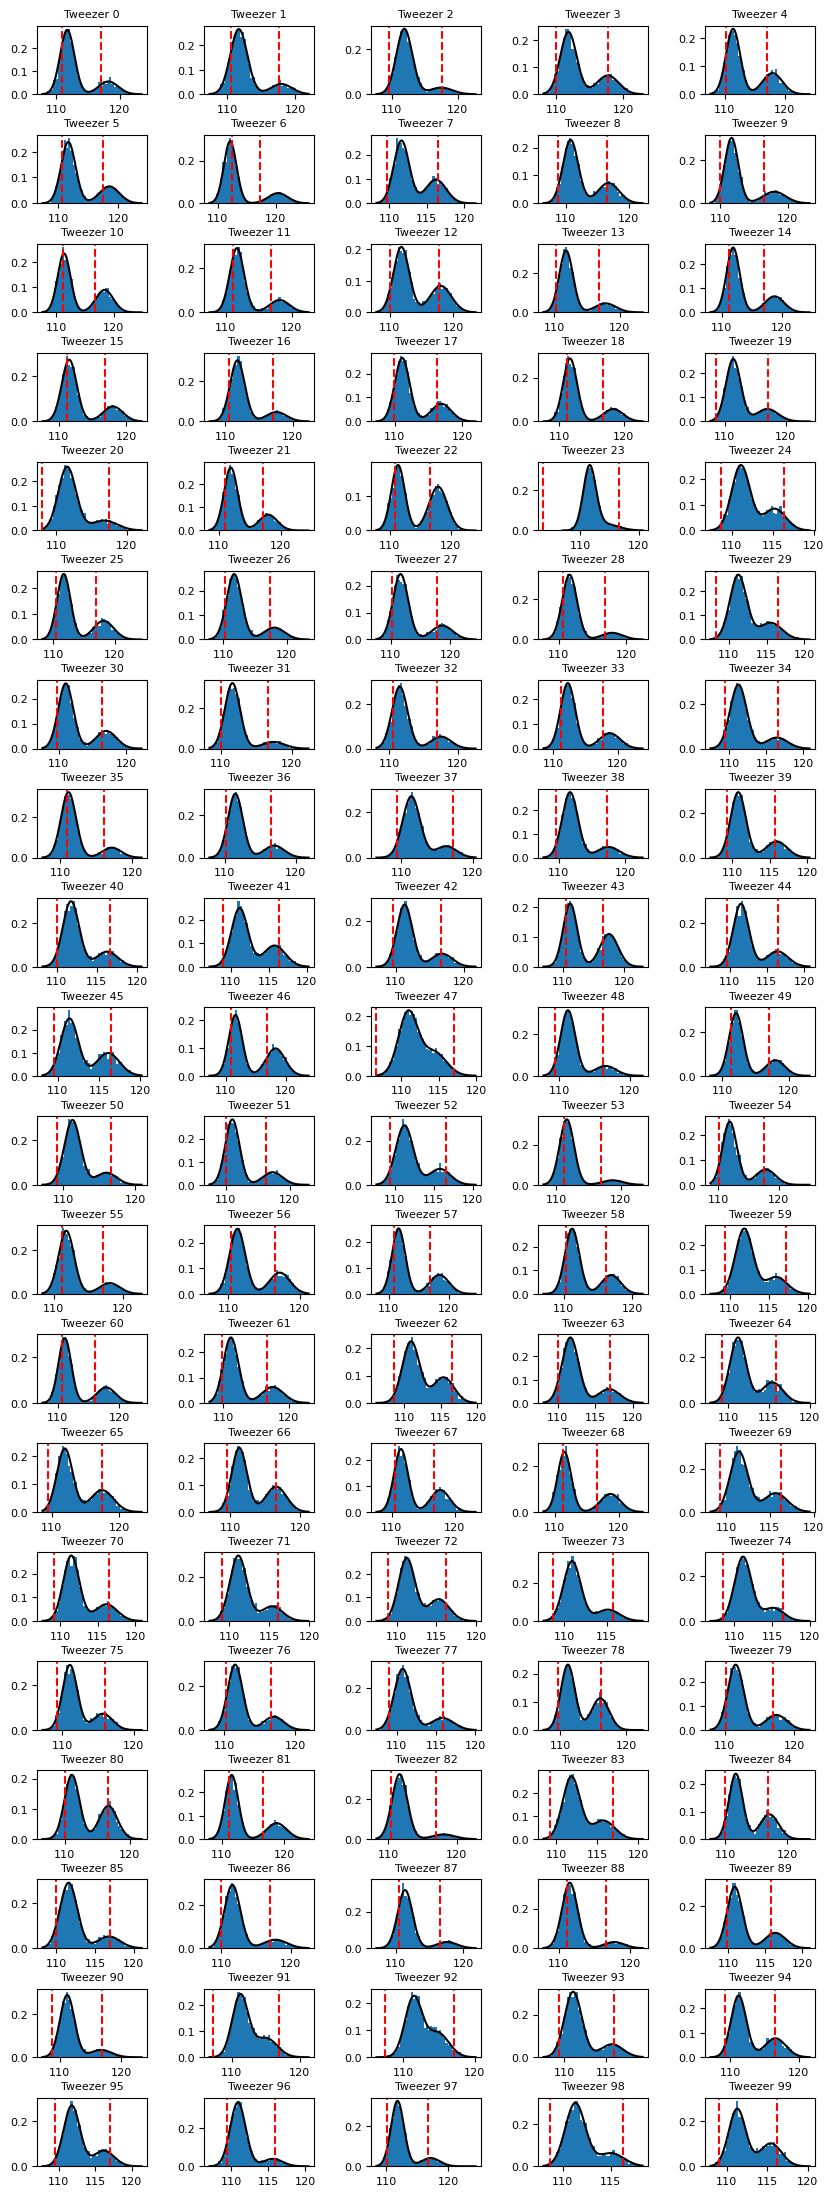

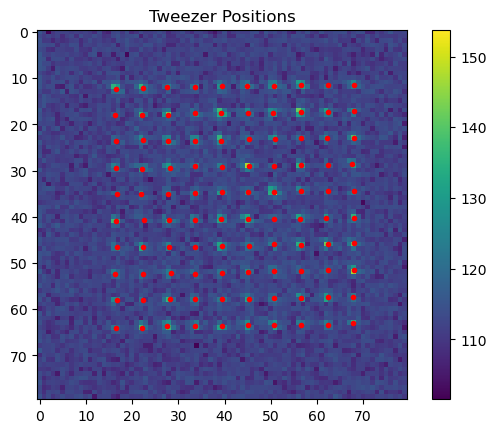

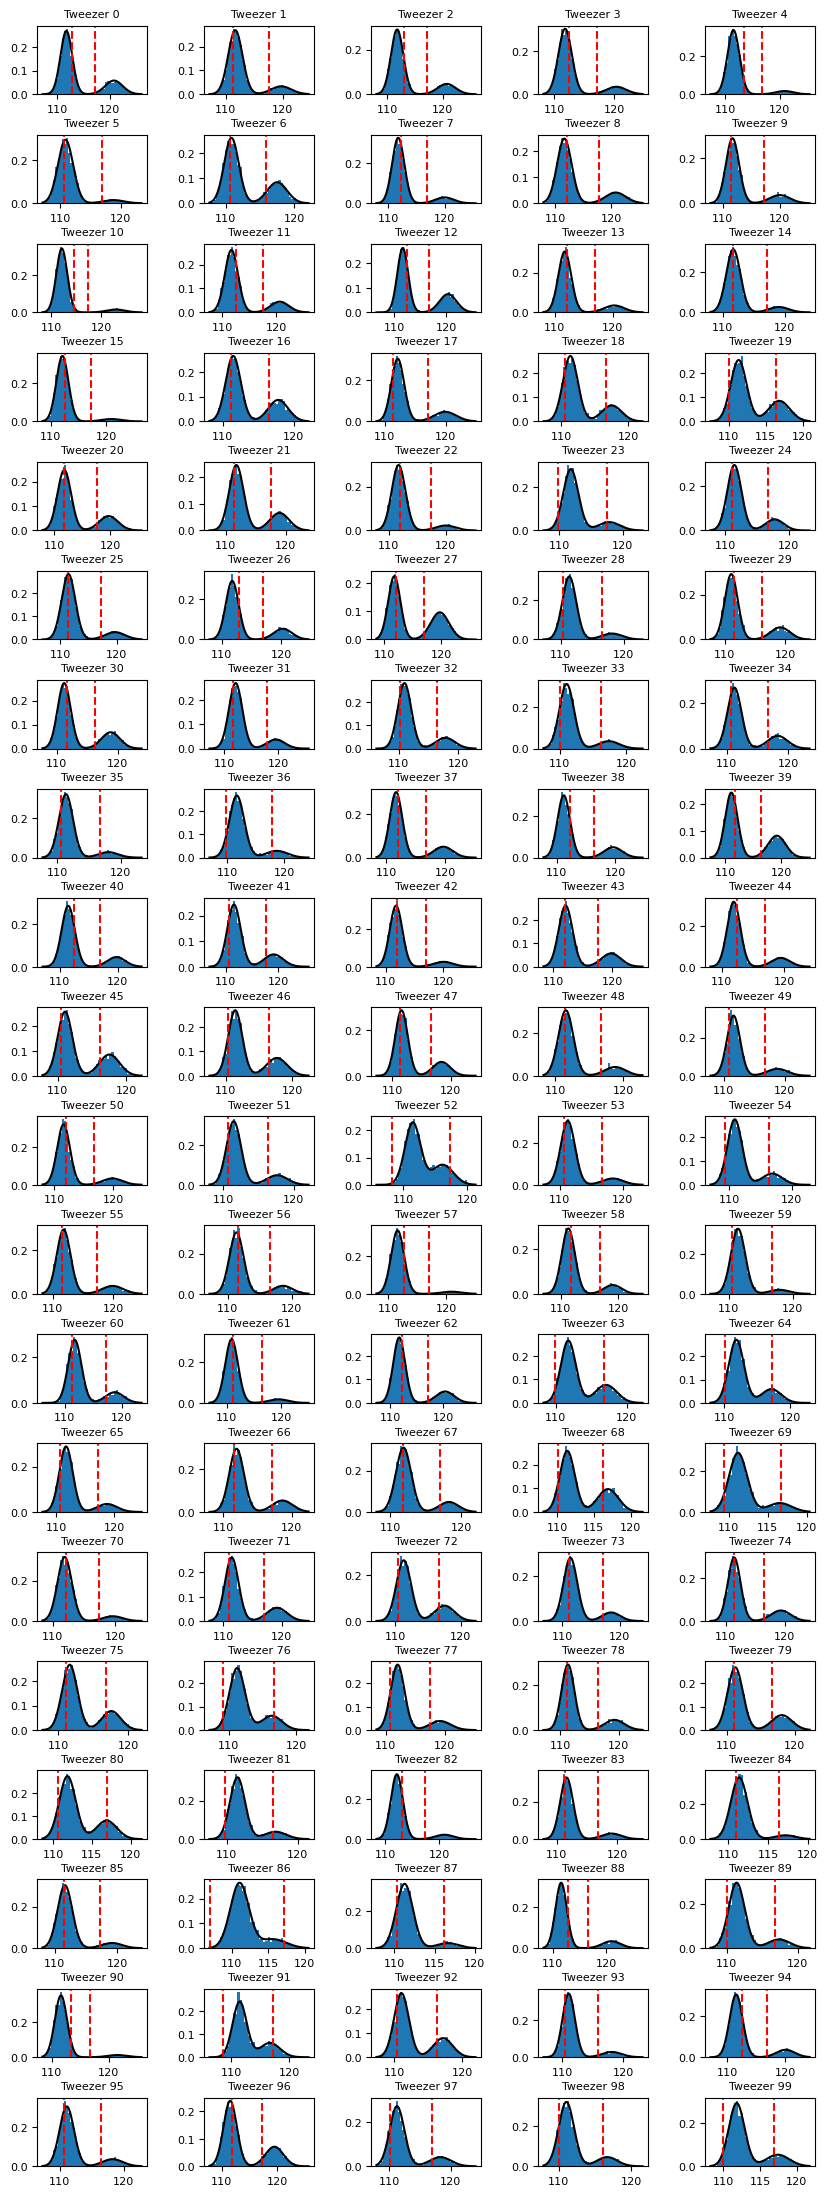

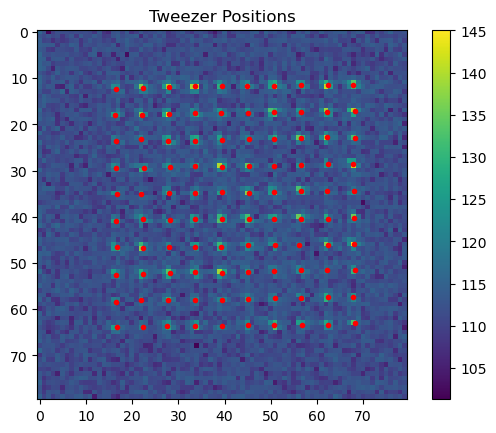

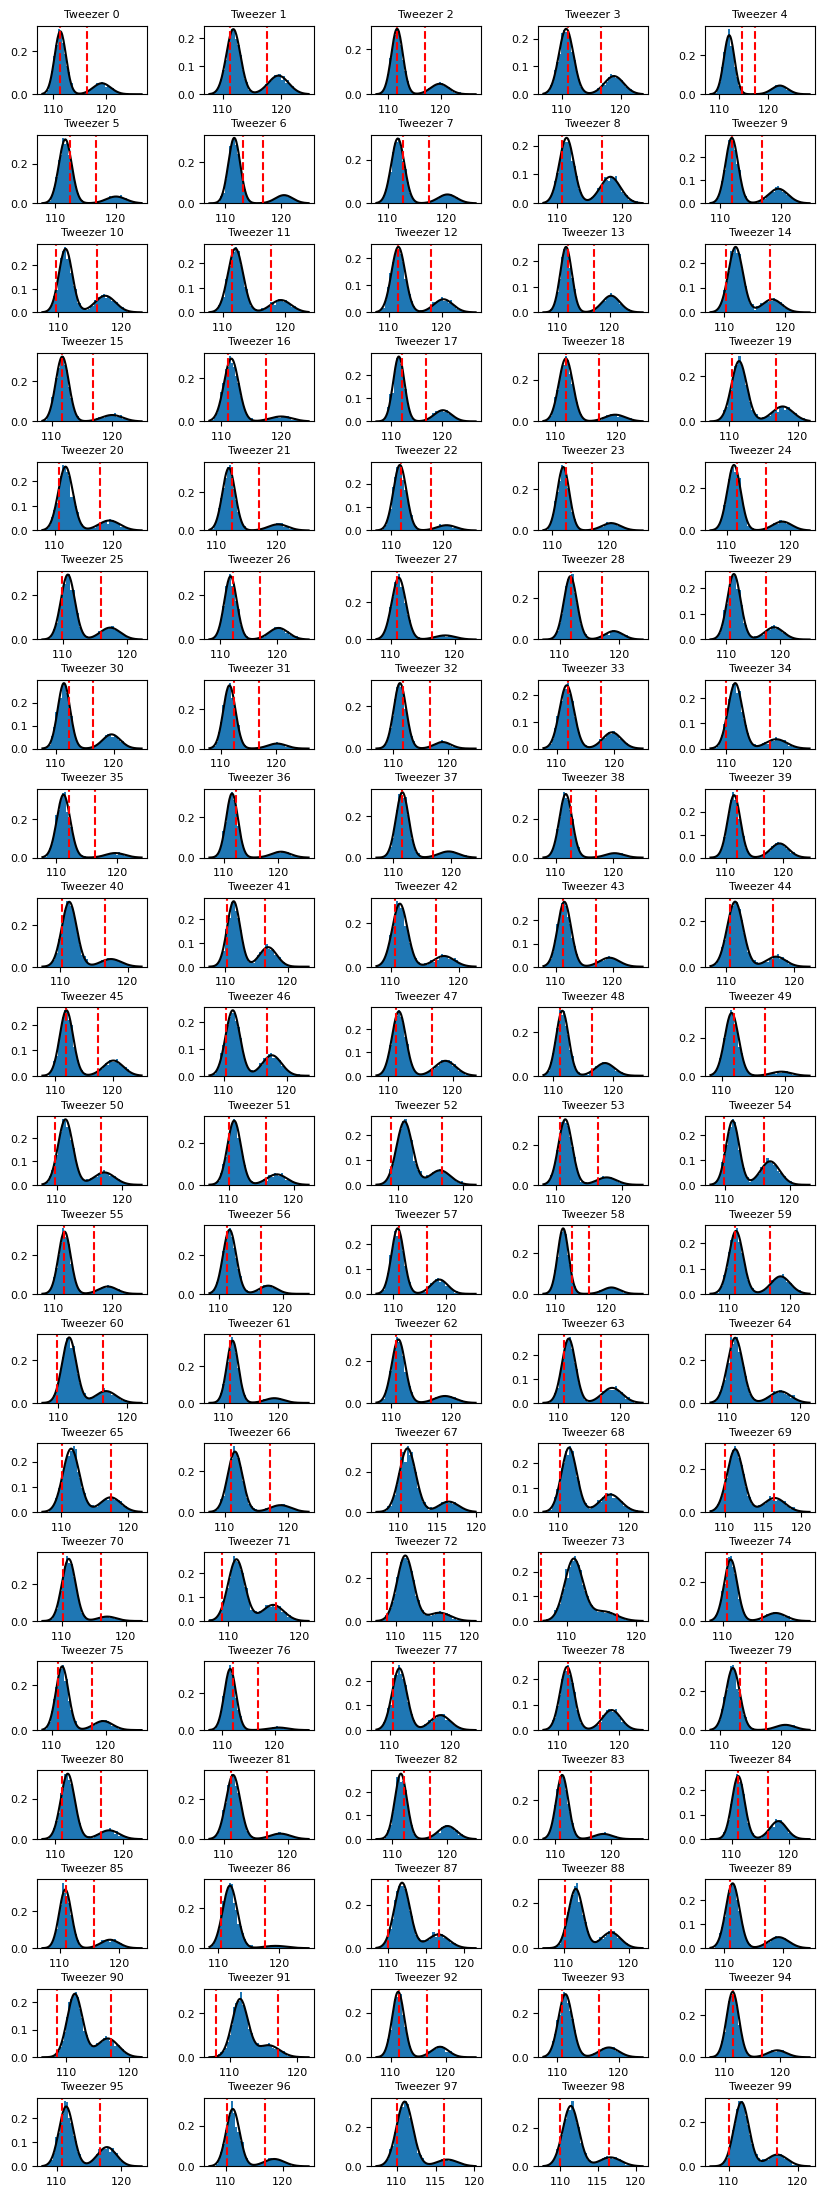

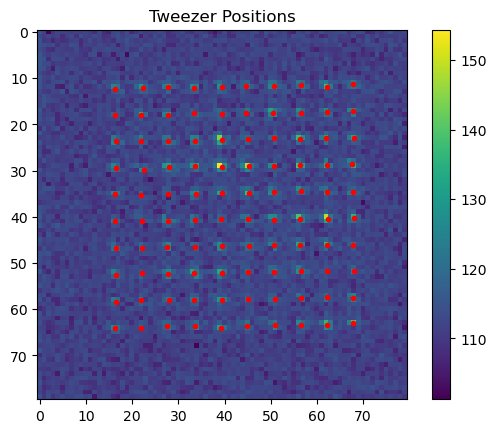

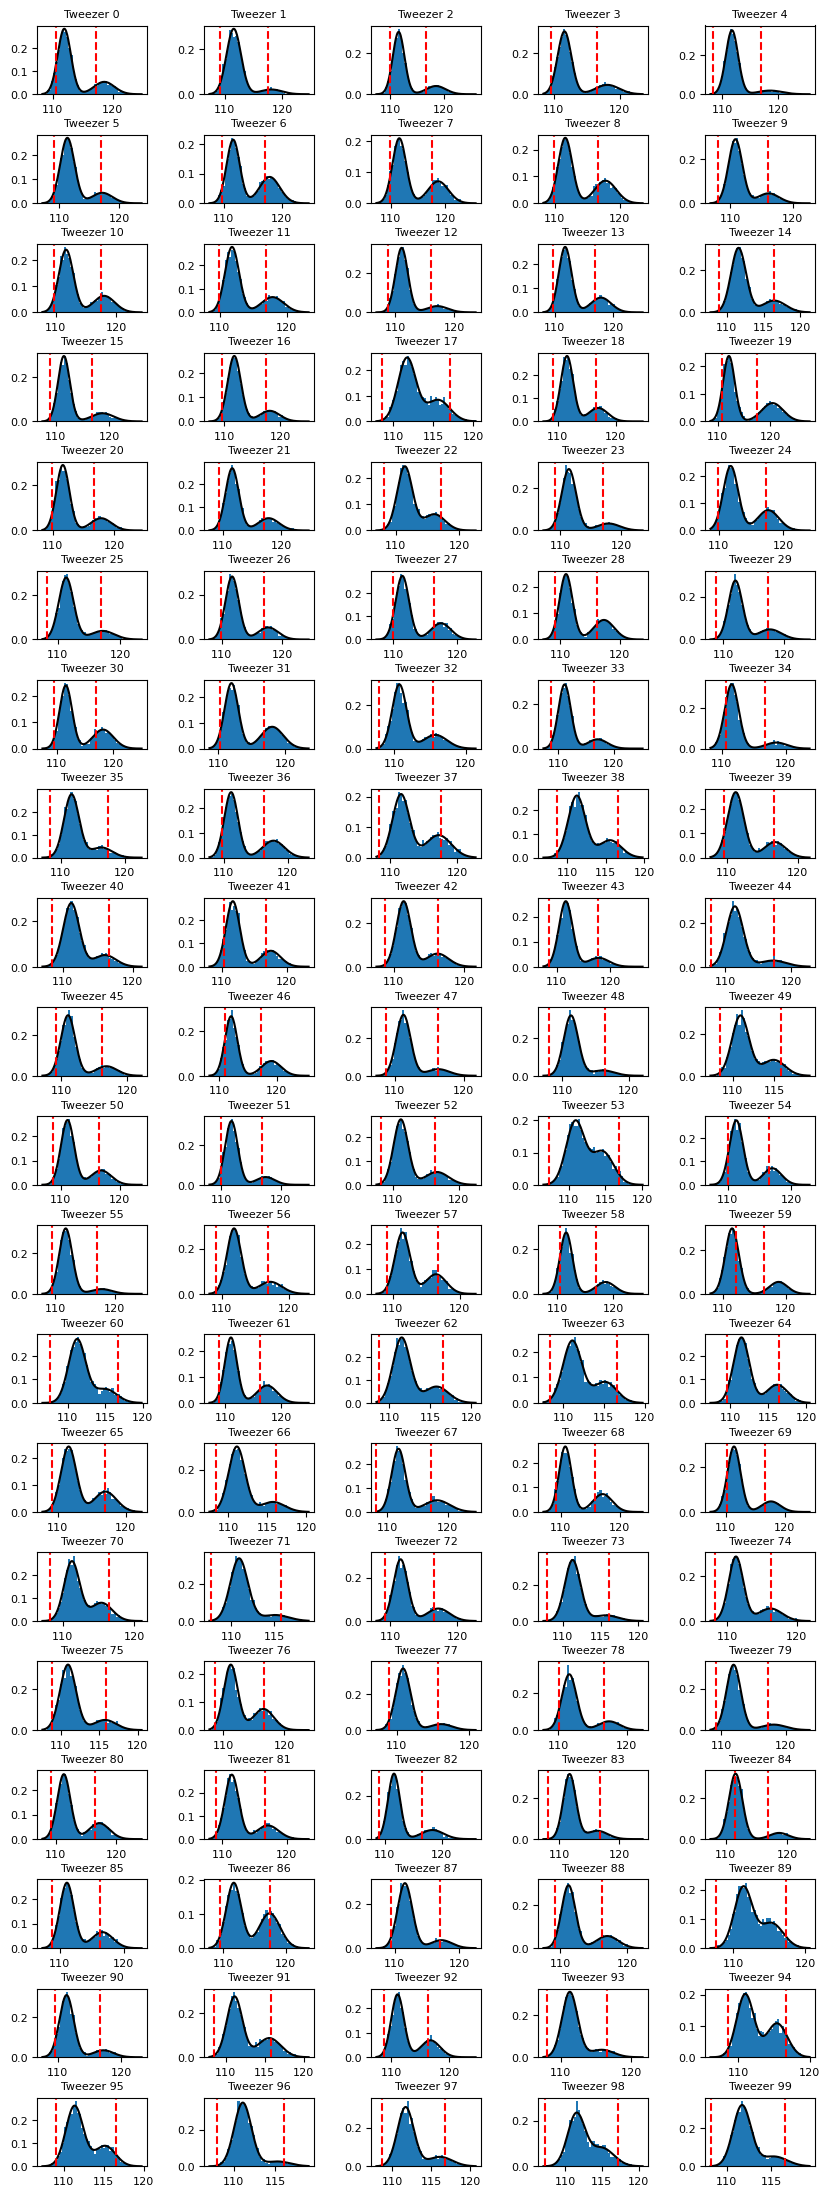

In [ ]:
combined_crops = []
combined_labels = []
for stack in combined_stack:
    processor = ImageProcessing.ImageProcessor(stack, n_tweezers, n_loops)
    crops3x3, crops1x1, positions, info = processor.run()
    labeler = Labeler.Labeler(crops1x1, n_tweezers, n_loops)
    labels, info = labeler.run()
    combined_crops.append(crops3x3)
    combined_labels.append(labels)
combined_crops = np.concatenate(combined_crops, axis=0)
combined_labels = np.concatenate(combined_labels, axis=0)

In [ ]:
builder = DatasetBuilder.DatasetBuilder(combined_crops, combined_labels)
training, testing, fidelity, info = builder.run()

In [ ]:
print(training[0].shape)

(1614412, 17, 17)


In [ ]:
model = architecture_1(crops3x3.shape[2:], [16, 8], [3, 3])
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy',
               metrics=['binary_accuracy'])


In [ ]:
trainer = ModelTrainer.ModelTrainer(model, training, testing, fidelity, n_tweezers, n_loops * n_files, epochs=8)
trainer.run()

Epoch 1/8
 5303/37838 [===>..........................] - ETA: 3:43 - loss: 0.0772 - binary_accuracy: 0.9747

KeyboardInterrupt: 